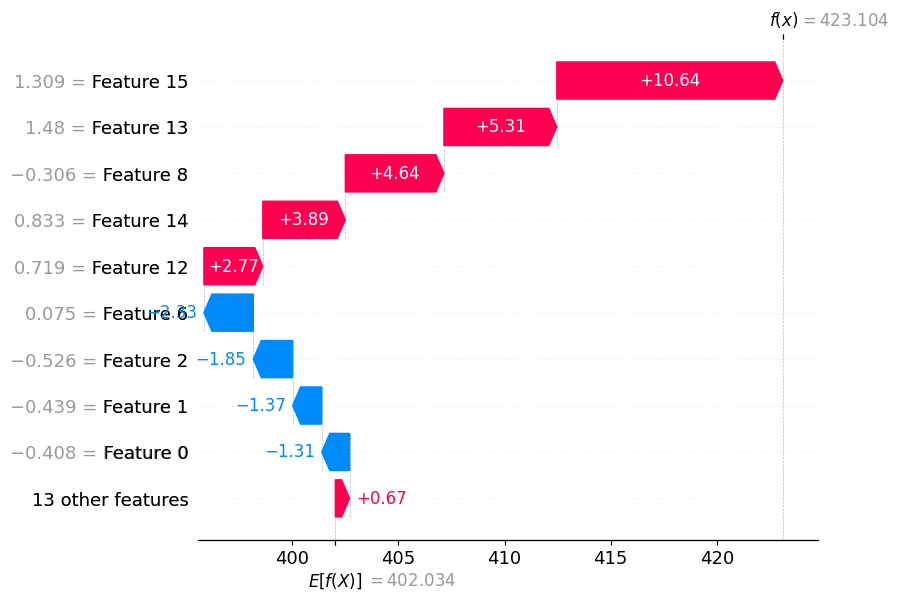

In [1]:

from sklearn.model_selection import train_test_split # Импортируем функцию train_test_split для разделения данных на обучающий и тестовый наборы
from scipy.stats import mstats
import pandas as pd #Импортируем pandas для удобства работы с данными
import shap
import pickle #Импортируем библиотеку, которая сохраняет модель
from sklearn.preprocessing import StandardScaler

df_train = pd.read_csv("C://Users//yegor//Desktop//datatech_internship//model//X_data.csv",sep = ";").rename(columns = {"Unnamed: 0":"Date"})

y_train = pd.read_csv("C://Users//yegor//Desktop//datatech_internship//model//Y_train.csv", sep=';', names=['Время забора пробы', 'Проба'])

outlier_columns = ['T_data_1_1', 'T_data_1_2', 'T_data_1_3', 'T_data_2_1', 'T_data_2_2', 'T_data_2_3',
'T_data_3_1', 'T_data_3_2', 'T_data_3_3', 'T_data_4_1', 'T_data_4_2', 'T_data_4_3',
'T_data_5_1', 'T_data_5_2', 'T_data_5_3', 'AH_data']

for col in outlier_columns:
    df_train[col] = mstats.winsorize(df_train[col], limits=[0.05, 0.05])

df_train['Date'] = pd.to_datetime(df_train['Date'], format='%d.%m.%Y %H:%M')
y_train['Время забора пробы'] = pd.to_datetime(y_train['Время забора пробы'], format='%d.%m.%Y %H:%M')


# Объединение по условию совпадения дат
merged_data = pd.merge(df_train, y_train, left_on='Date', right_on='Время забора пробы', how='inner')
merged_data.drop("Время забора пробы",axis = 1,inplace = True)
merged_data['Date'] = pd.to_datetime(merged_data['Date'], format='%d.%m.%Y %H:%M')

# Создание новых признаков на основе колонки 'Date'
merged_data['Year'] = merged_data['Date'].dt.year
merged_data['Month'] = merged_data['Date'].dt.month
merged_data['Day'] = merged_data['Date'].dt.day
merged_data['Hour'] = merged_data['Date'].dt.hour
merged_data['Minute'] = merged_data['Date'].dt.minute
merged_data.drop("Date",axis = 1,inplace = True)


X = merged_data.drop(['Проба'], axis=1)
y = merged_data['Проба']


X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

scaler = StandardScaler()

# Применение StandardScaler к обучающему набору данных (fit_transform)
X_train = scaler.fit_transform(X)

# Применение StandardScaler к тестовому набору данных (transform)
X_test = scaler.transform(X_test)


with open('C://Users//yegor//Desktop//datatech_internship//model//lr_reg.pkl', 'rb') as file:
    model = pickle.load(file)

explainer = shap.Explainer(model, X_train)

# Получение SHAP значений для тестового набора данных
shap_values = explainer(X_test)

# Визуализация SHAP значений
shap.plots.waterfall(shap_values[0])


SHAP — это метод объяснения предсказаний моделей машинного обучения, основанный на теории игр, в частности на Шаплиевых значениях. Он позволяет оценить вклад каждого признака в предсказание модели для конкретного экземпляра данных.
#### Основные принципы:
1. **Шаплиевы значения**:
- SHAP использует концепцию Шаплиевых значений, которые распределяют "выигрыш" (в данном случае предсказание модели) между "игроками" (признаками) на основе их вклада.
- Каждый признак рассматривается как игрок в кооперативной игре, где цель — максимизировать предсказание модели.
2. **Локальная интерпретация**:
- SHAP предоставляет локальные объяснения, что означает, что он объясняет, как каждый признак влияет на предсказание для конкретного экземпляра данных.
3. **Аддитивность**:
- SHAP гарантирует, что сумма всех вкладов признаков равна предсказанию модели. Это позволяет легко интерпретировать результаты.
### Как вычисляется важность признаков с помощью SHAP
1. **Обучение модели**:
- Сначала обучается модель на обучающем наборе данных.
2. **Вычисление базового предсказания**:
- Определяется базовое предсказание (например, среднее значение целевой переменной) для случая, когда все признаки равны нулю.
3. **Вычисление Шаплиевых значений**:
- Для каждого признака и для каждого экземпляра данных вычисляются Шаплиевы значения. Это делается путем оценки влияния каждого признака на предсказание модели, учитывая все возможные комбинации признаков.
- Формула для вычисления Шаплиевого значения для признака \( j \) может быть представлена как:
$$
\phi_j = \sum_{S \subseteq N \setminus \{j\}} \frac{|S|! \cdot (|N| - |S| - 1)!}{|N|!} \left( f(S \cup \{j\}) - f(S) \right)
$$

где:
$$
\begin{align*}
- & \phi_j \text{ — Шаплиево значение для признака } j. \\
- & N \text{ — множество всех признаков.} \\
- & S \text{ — подмножество признаков, которое не включает признак } j \text{ (то есть } S \subseteq N \setminus \{j\}). \\
- & |S| \text{ — количество признаков в подмножестве } S. \\
- & |N| \text{ — общее количество признаков в множестве } N. \\
- & f(S) \text{ — предсказание модели, сделанное с использованием признаков из подмножества } S. \\
- & f(S \cup \{j\}) \text{ — предсказание модели, сделанное с использованием признаков из подмножества } S \text{ плюс признак } j.
\end{align*}
$$


4. **Суммирование вкладов**:
- Важность каждого признака для конкретного предсказания определяется как сумма его Шаплиевых значений.
5. **Визуализация**:
- Результаты могут быть визуализированы с помощью различных графиков, таких как графики зависимости, графики значимости и другие, что позволяет лучше понять влияние каждого признака

# Объяснение работы функции `shap.plots.waterfall()`

Функция `shap.plots.waterfall()` из библиотеки SHAP (SHapley Additive exPlanations) предназначена для визуализации вклада каждого признака в предсказание модели для конкретного примера. Этот график особенно полезен для понимания, как каждый признак влияет на итоговое предсказание, начиная с базового значения (обычно среднего предсказания по всему набору данных) и добавляя или вычитая вклады каждого признака по порядку.

## Компоненты графика waterfall:

1. **`E[f(x)]`**:
   - Это ожидаемое значение предсказания модели для всего набора данных или базовое значение, с которого начинается расчет вкладов признаков.
   - Обычно представляет собой среднее предсказание модели по всем обучающим или тестовым данным.

2. **`f(x)`**:
   - Это предсказание модели для конкретного примера данных, для которого строится график waterfall.
   - Является результатом работы модели на входных данных `x`.

3. **Цвета фичей (синий и красный)**:
   - Синий цвет обозначает, что вклад признака увеличивает предсказание (положительный вклад).
   - Красный цвет указывает на то, что вклад уменьшает предсказание (отрицательный вклад).

4. **Значения (+ или -)**:
   - Рядом с каждым признаком указано значение его вклада в предсказание.
   - Значение может быть положительным или отрицательным, в зависимости от того, увеличивает или уменьшает ли вклад этого признака итоговое предсказание.
   - Сумма всех этих значений (включая базовое значение `E[f(x)]`) должна дать итоговое предсказание `f(x)` для данного примера.
